# Signal to noise calculations for the Australian Space Eye proposal

This notebook contains signal to noise calculations for the Australian Space Eye CubeSat space telescope proposal. The signal to noise/sensitivity are estimated for the main science aims of the mission, specifically absolute photometry of the Cosmic Infrared Background (CIB) and Zodiacal Light (ZL), and low surface brightness imaging of low redshift galaxies.

Two filter sets are considered:

1. 2 sets of 3 variant i and z band filters, designed to create 'virtual narrowband filters' in the Calcium triplet region in order to separate the CIB and ZL components.
1. 2 broadband i and z filters and 2 narrowband Calcium triplet 'on' and 'off' filters.

In each case each filter receives an equal share of the observing time.

## Standard imports

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
from IPython.display import HTML
import astropy.units as u
from astropy.table import Table

In [4]:
# Minimal, uncluttered notebook display of astropy Tables
def show_no_dtype(astropy_table):
    return HTML('\n'.join(astropy_table.pformat(html=True,
                                                show_dtype=False,
                                                tableclass="table-condensed table-bordered")))

## Import gunagala

`gungala` is the library that performs the SNR/sensitivity/ETC calculations. The main submodule is `imager` which includes the `Imager` class which represents an astronomical imaging instrument.

In [5]:
from gunagala import imager

/Users/ajh/anaconda/envs/POCS/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Create imagers

The `gunagala.imager.create_imagers()` creates a dictionary of `Imager` objects based on the `gunagala/data/performance.yaml` configuration file as well as performance data files in `gunagala/data/performance_data`. The instrument configuration/specifications should be set by editing these files.

Currently the file describes 3 variants of the Australian Space Eye concept and, for comparison, a 5 lens version of the Huntsman Telephoto Array.

In [6]:
imagers = imager.create_imagers()

huntsman = imagers['canon_sbig']  # A 5 lens array

ase_2016 = imagers['ase_2016']  # 6U with 1x 90 mm telescope & overlapping broadband filters
ase_2017 = imagers['ase_2017']  # 6U with 1x 90 mm telescope & broad and narrowband filters

waves_h = huntsman.wavelengths
waves_a = ase_2016.wavelengths

## Inspect imager properties

Many properties of the imagers can be accessed as properties of the `Imager` object.

### Filter profiles 

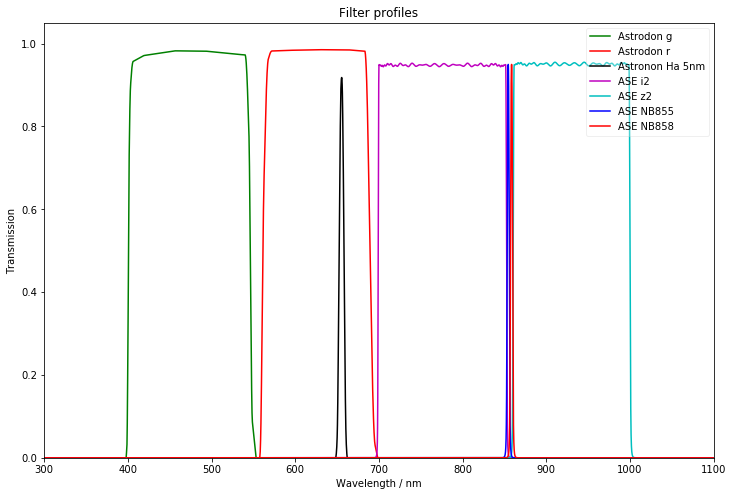

In [7]:
plt.plot(waves_h, huntsman.filters['g'].transmission(waves_h), 'g-', label='Astrodon g')
plt.plot(waves_h, huntsman.filters['r'].transmission(waves_h), 'r-', label='Astrodon r')
plt.plot(waves_h, huntsman.filters['Ha_5nm'].transmission(waves_h), 'k-', label='Astronon Ha 5nm')
#plt.plot(waves_h, huntsman.filters['Ha_3nm'].transmission(waves_h), 'k-', label='Astronon Ha 3nm')


plt.plot(waves_a, ase_2017.filters['ase_i1'].transmission(waves_a), 'm-', label='ASE i2')
plt.plot(waves_a, ase_2017.filters['ase_z3'].transmission(waves_a), 'c-', label='ASE z2')
plt.plot(waves_a, ase_2017.filters['ase_nb855'].transmission(waves_a), 'b-', label='ASE NB855')
plt.plot(waves_a, ase_2017.filters['ase_nb858'].transmission(waves_a), 'r-', label='ASE NB858')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Filter profiles')
plt.xlim(300, 1100)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

In [8]:
ase_2017.filters['ase_nb855'].FWHM

<Quantity 2.658233245264455 nm>

In [9]:
ase_2017.filters['ase_nb855'].lambda_c

<Quantity 854.3935690666981 nm>

In [10]:
ase_2017.filters['ase_nb858'].FWHM

<Quantity 2.666089320008723 nm>

In [11]:
ase_2017.filters['ase_nb858'].lambda_c

<Quantity 858.3907297645989 nm>

### Image sensor quantum efficiency

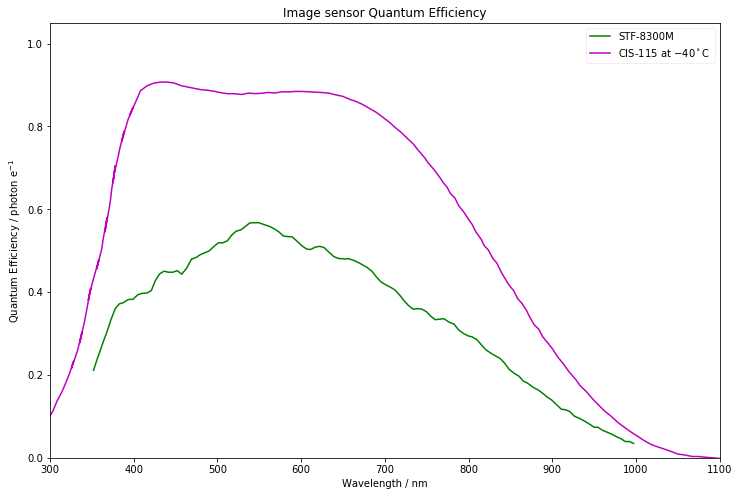

In [12]:
plt.plot(huntsman.camera.wavelengths, huntsman.camera.QE, 'g-', label='STF-8300M')
plt.plot(ase_2017.camera.wavelengths, ase_2017.camera.QE, 'm-', label='CIS-115 at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Quantum Efficiency / photon e$^{-1}$')
plt.title('Image sensor Quantum Efficiency')
plt.xlim(300, 1100)
plt.ylim(0,1.05)
plt.gcf().set_size_inches(12,8)

### End to end efficiency

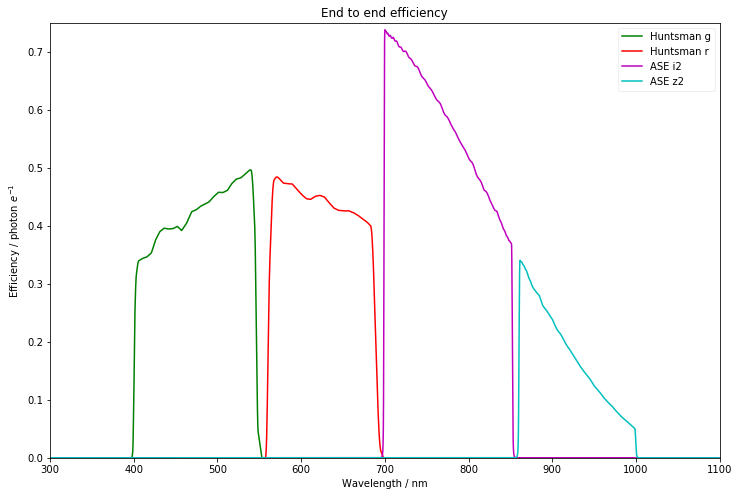

In [13]:
plt.plot(waves_h, huntsman.efficiencies['g'], 'g-', label='Huntsman g')
plt.plot(waves_h, huntsman.efficiencies['r'], 'r-', label='Huntsman r')

plt.plot(waves_a, ase_2017.efficiencies['ase_i1'], 'm-', label='ASE i2')
plt.plot(waves_a, ase_2017.efficiencies['ase_z3'], 'c-', label='ASE z2')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Efficiency / photon $e^{-1}$')
plt.title('End to end efficiency')
plt.xlim(300, 1100)
plt.ylim(0, 0.75)
plt.gcf().set_size_inches(12,8)

### Sky background model

For ASE the sky background is expected to dominated by the Zodiacal Light. For this we are use a scaled, reddened Solar spectrum following the prescription used by the HST ETC.

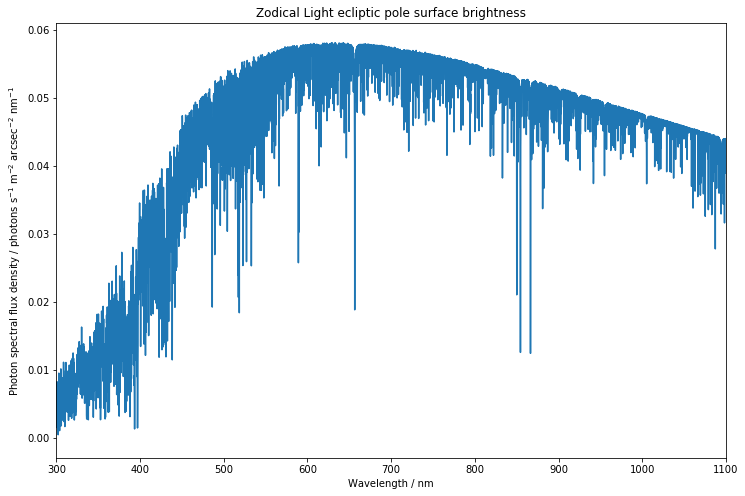

In [14]:
plt.plot(ase_2017.sky.waves.to(u.nm), 
         ase_2017.sky.photon_sfd.to(u.photon * u.s**-1 * u.m**-2 * u.arcsecond**-2 * u.nm**-1))
plt.xlim(300, 1100)
plt.title('Zodical Light ecliptic pole surface brightness')
plt.xlabel('Wavelength / nm')
plt.ylabel('Photon spectral flux density / photons s$^{-1}$ m$^{-2}$ arcsec$^{-2}$ nm$^{-1}$')
plt.gcf().set_size_inches(12, 8)

### Filter transmission profile details


#### Virtual narrowband filter set

Close up of the blue edge of the 3 z band filter variants, shown together with the Zodiacal Light spectrum and its Calcium triplet absorption lines.

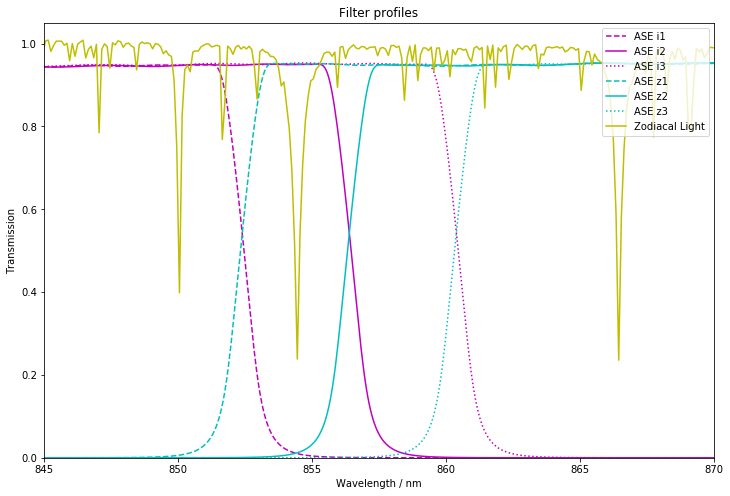

In [15]:
plt.plot(waves_a, ase_2016.filters['ase_i1'].transmission(waves_a), 'm--', label='ASE i1')
plt.plot(waves_a, ase_2016.filters['ase_i2'].transmission(waves_a), 'm-', label='ASE i2')
plt.plot(waves_a, ase_2016.filters['ase_i3'].transmission(waves_a), 'm:', label='ASE i3')

plt.plot(waves_a, ase_2016.filters['ase_z1'].transmission(waves_a), 'c--', label='ASE z1')
plt.plot(waves_a, ase_2016.filters['ase_z2'].transmission(waves_a), 'c-', label='ASE z2')
plt.plot(waves_a, ase_2016.filters['ase_z3'].transmission(waves_a), 'c:', label='ASE z3')

plt.plot(ase_2017.sky.waves.to(u.nm), 1.1 *ase_2017.sky.photon_sfd/ase_2017.sky.photon_sfd.max(), 'y-', label='Zodiacal Light')

plt.legend(loc='upper right', fancybox=True, framealpha=0.8)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Filter profiles')
plt.xlim(845, 870)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

The 'virtual narrowband filters' that result from the pair-wise differences between the 3 z band filters coincide with the strongest Ca-triplet absorption line and adjacent continuum.  Meaurements of the sky background in these 3 filters therefore allow a measurement of the depth of the Ca-triplet absorption.



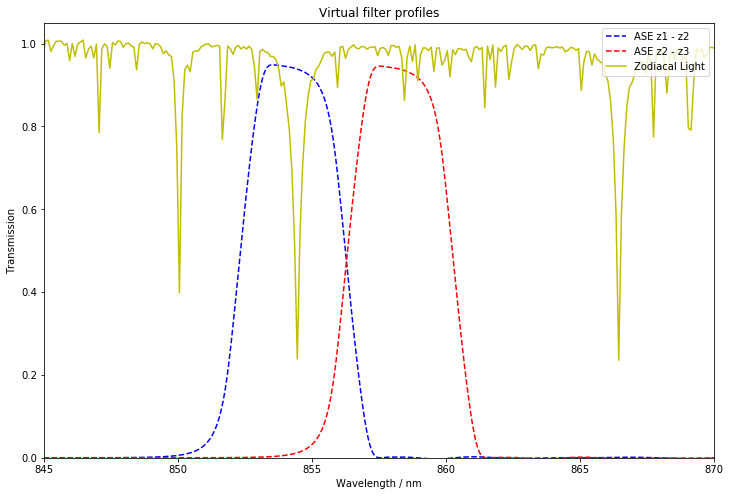

In [16]:
plt.plot(waves_a, 
         ase_2016.filters['ase_z1'].transmission(waves_a) - ase_2016.filters['ase_z2'].transmission(waves_a),
         'b--', label='ASE z1 - z2')
plt.plot(waves_a,
         ase_2016.filters['ase_z2'].transmission(waves_a) - ase_2016.filters['ase_z3'].transmission(waves_a),
         'r--', label='ASE z2 - z3')

plt.plot(ase_2017.sky.waves.to(u.nm), 1.1 * ase_2017.sky.photon_sfd/ase_2017.sky.photon_sfd.max(), 
         'y-', label='Zodiacal Light')

plt.legend(loc='upper right', fancybox=True, framealpha=0.8)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Virtual filter profiles')
plt.xlim(845, 870)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

#### Standard filter set

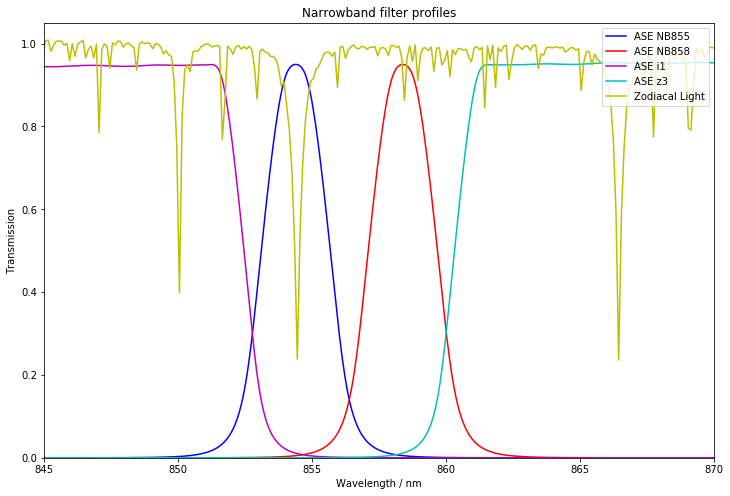

In [17]:
plt.plot(waves_a, ase_2017.filters['ase_nb855'].transmission(waves_a), 'b-', label='ASE NB855')
plt.plot(waves_a, ase_2017.filters['ase_nb858'].transmission(waves_a), 'r', label='ASE NB858')

plt.plot(waves_a, ase_2016.filters['ase_i1'].transmission(waves_a), 'm-', label='ASE i1')
plt.plot(waves_a, ase_2016.filters['ase_z3'].transmission(waves_a), 'c-', label='ASE z3')

plt.plot(ase_2017.sky.waves.to(u.nm), 1.1 * ase_2017.sky.photon_sfd/ase_2017.sky.photon_sfd.max(), 
         'y-', label='Zodiacal Light')

plt.legend(loc='upper right', fancybox=True, framealpha=0.8)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Narrowband filter profiles')
plt.xlim(845, 870)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

### Detected sky background levels

Pre-calculated for each filter. Also dark current for comparison.

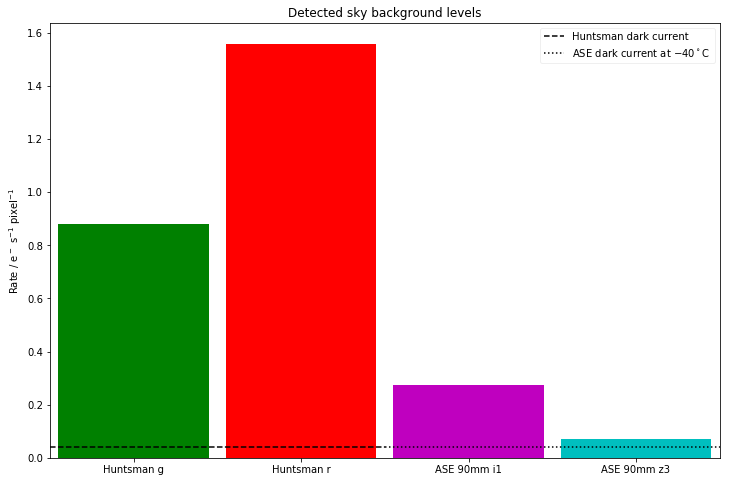

In [18]:
plt.bar((1, 2), (huntsman.sky_rate['g'].value, huntsman.sky_rate['r'].value),
        width=0.9, align='center', color=('g', 'r'))
plt.hlines(huntsman.camera.dark_current.value, 0.5, 2.5, linestyle='dashed', label='Huntsman dark current')

plt.bar((3, 4), (ase_2017.sky_rate['ase_i1'].value,
                       ase_2017.sky_rate['ase_z3'].value),
        width=0.9, align='center', color=('m', 'c'))
plt.hlines(ase_2017.camera.dark_current.value, 2.5, 6.5, linestyle='dotted', label='ASE dark current at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)


plt.xticks((1, 2, 3, 4), 
           ('Huntsman g', 'Huntsman r', 'ASE 90mm i1', 'ASE 90mm z3'))
plt.xlim(0.5,4.5)
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels')
plt.gcf().set_size_inches(12, 8)

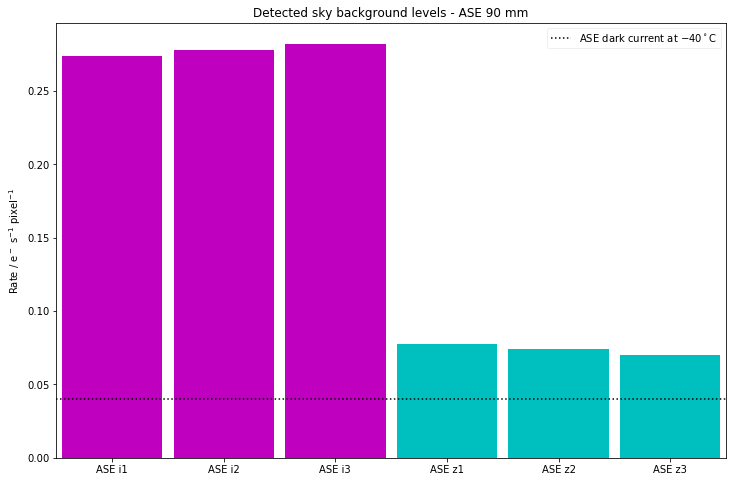

In [19]:
plt.bar((1, 2, 3, 4, 5, 6),
        (ase_2016.sky_rate['ase_i1'].value,
         ase_2016.sky_rate['ase_i2'].value,
         ase_2016.sky_rate['ase_i3'].value,
         ase_2016.sky_rate['ase_z1'].value,
         ase_2016.sky_rate['ase_z2'].value,
         ase_2016.sky_rate['ase_z3'].value),
        width=0.9, align='center', color=('m', 'm', 'm', 'c', 'c', 'c'))
plt.hlines(ase_2016.camera.dark_current.value, 0.5, 6.5, linestyle='dotted', label='ASE dark current at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlim(0.5,6.5)
plt.xticks((1, 2, 3, 4, 5, 6), ('ASE i1', 'ASE i2', 'ASE i3', 'ASE z1', 'ASE z2', 'ASE z3'))
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels - ASE 90 mm')

plt.gcf().set_size_inches(12, 8)

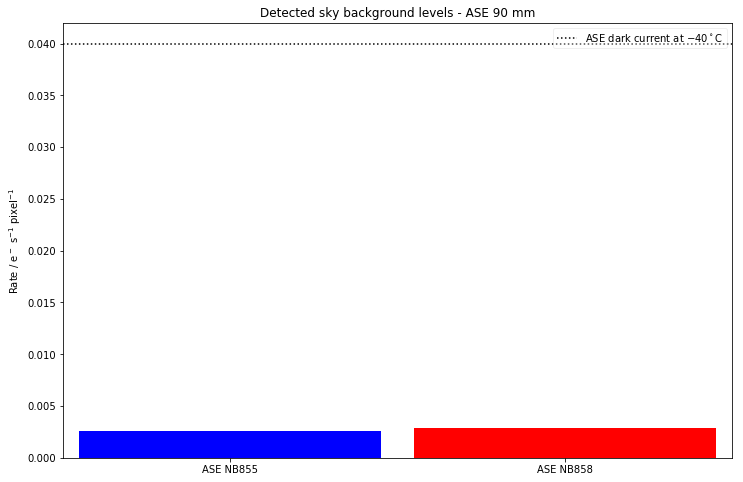

In [20]:
plt.bar((1, 2),
         (ase_2017.sky_rate['ase_nb855'].value,
          ase_2017.sky_rate['ase_nb858'].value),
          width=0.9, align='center', color=('b', 'r', 'b', 'r'))

plt.hlines(ase_2016.camera.dark_current.value, 0.5, 6.5, linestyle='dotted', label='ASE dark current at $-40^\circ$C')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlim(0.5,2.5)
plt.xticks((1, 2), ('ASE NB855', 'ASE NB858'))
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels - ASE 90 mm')

plt.gcf().set_size_inches(12, 8)

## Broadband imaging sensitivity

For broadband i and z band imaging we combine the data from all the i band and all the z band filters together.

We expect to observe for approximately 40 minutes of each 100 minute orbit.  Individual sub exposures that therefore be up to 40 minutes long, cosmic rays permitting.

Nominal mission duration is 2 years, allowing up to several months on each target field.

In [21]:
duty_cycle = 40 / 100

### Basic extended source sensitivity, 1 month

Limiting surface brightness in AB magnitudes per square arcsecond given a signal to noise ratio threshold of 1.0 per arcsecond squared and 1 month on target.

#### Virtual narrowband filter set

Here we can consider the 3 variant i and 3 variant z filters to be essentially the same and sum them together. The effective fraction of total exposure time for either or i or z band is then 1/2.

In [22]:
filter_fraction = 3 / 6

iasv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i2',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')

zasv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z2',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')

#### Standard broadband filters

Here we have i, z, and 2 narrowband filters. Assuming each are given equal exposure time then each broadband filter gets 1/4 of the total exposure time.

In [23]:
filter_fraction = 1 / 4

iasb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i1',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')

zasb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z3',
                                      snr_target=1.0,
                                      calc_type='per arcsecond squared')

#### Results

In [24]:
t1 = Table(data = (('Virtual narrowband', 'Standard broadband'),
                   u.Quantity((iasv, iasb)).round(decimals=2),
                   u.Quantity((zasv, zasb)).round(decimals=2)),
           names=('Filter set', 'i band', 'z band'))
show_no_dtype(t1)

Filter set,i band,z band
,mag(AB),mag(AB)
Virtual narrowband,27.97,26.98
Standard broadband,27.58,26.56


### Extended source sensitivity, 1 months with binning

Our highest priority science targets will be very extended, allowing significant spatial binning after removal of compact source contaminants. For these a signal to noise threshold of, say, 1.0 per square _arcminute_ may be more appropriate than square arcsecond.  This is equivalent to an SNR of 1/60 per square arcsecond.

#### Virtual narrowband filter set

In [25]:
filter_fraction = 3 / 6

iamv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i2',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')

zamv = ase_2016.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z2',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')

#### Standard broadband filters

In [26]:
filter_fraction = 1 / 4

iamb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_i1',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')

zamb = ase_2017.extended_source_limit(total_exp_time = 1 * 30 * u.day * duty_cycle * filter_fraction,
                                      sub_exp_time = 40 * u.minute,
                                      filter_name = 'ase_z3',
                                      snr_target=1.0 / 60,
                                      calc_type='per arcsecond squared')

#### Results

In [27]:
t2 = Table(data = (('Virtual narrowband', 'Standard broadband'),
                   u.Quantity((iamv, iamb)).round(decimals=2),
                   u.Quantity((zamv, zamb)).round(decimals=2)),
           names=('Filter set', 'i band', 'z band'))
show_no_dtype(t2)

Filter set,i band,z band
,mag(AB),mag(AB)
Virtual narrowband,32.42,31.43
Standard broadband,32.03,31.01


## Cosmic Infrared Background & Zodiacal Light measurements

The Cosmic Infrared Background (CIB) and Zodiacal Light (ZL) are both components of the sky background, with ZL being the dominant one. ASE aims to measure the absolute surface brightness of both using multiband photometry, taking advantage of the Calcium triplet absorption features in the ZL spectrum.  The Zodical Light is expected to have equal Ca-triplet depth to the Solar spectrum while the extragalactic background light will not exhibit any absorption lines. Consequently a measurement of the sky background Ca-triplet absorption depth allows the separation of Zodical Light and extragalactic components.

In practice the measurement of the CIB and ZL will be acheived by fitting models to the multiband photometry from ASE. In order to estimate the signal to noise in the fitted parameters we will use a highly simplified model and fitting procedure.



Lower limits on integrated galactic light (EGL) from Driver et al 2017. There are expressed in terms of total flux for each band, need to use approximate filter bandwidths to convert these to a (band averaged) spectral flux density, convert to photon based units and interpolate across all the Space Eye filters.

In [28]:
cib_waves = (0.749, 0.895) * u.micron # Pivot wavelengths
cib_limit = (9.35, 9.98) * u.W * u.m**-2 * u.sr**-1 / 1e9 # Lower limits, bandpass totals

In [29]:
cib_limit_sfd = (cib_limit / (150 * u.nm)).to(u.W * u.m**-2 * u.arcsecond**-2 * u.nm**-1) # Divide by bandpass
cib_limit_sfd

<Quantity [  1.46510950e-21,  1.56382811e-21] W / (arcsec2 m2 nm)>

In [30]:
cib_unsurface_brightness = cib_limit_sfd * u.arcsecond**2 # Need to change units to use spectral_density equivalencies
cib_limit_photon = cib_unsurface_brightness.to(u.photon * u.s**-1 * u.m**-2 * u.nm**-1, 
                                    equivalencies=u.equivalencies.spectral_density(cib_waves))
cib_limit_photon = cib_limit_photon / u.arcsecond**2 # Change back to surface brightness units
cib_limit_photon

<Quantity [ 0.00552427, 0.00704588] ph / (arcsec2 m2 nm s)>

Use a simple linear interpolation of these values as an approximate model for the CIB spectral flux density.

In [31]:
cib_gradient = (cib_limit_photon[1] - cib_limit_photon[0]) / (cib_waves[1] - cib_waves[0])
cib_gradient = cib_gradient.to(u.photon * u.s**-1 * u.nm**-2 * u.arcsecond**-2 * u.m**-2)
cib_gradient

<Quantity 1.042197183037569e-05 ph / (arcsec2 m2 nm2 s)>

In [32]:
cib_intercept = cib_limit_photon[0] - (cib_gradient * cib_waves[0])
cib_intercept

<Quantity -0.0022817829304033034 ph / (arcsec2 m2 nm s)>

In [33]:
cib_model = lambda w: (cib_gradient * w + cib_intercept).to(u.photon * u.s**-1 * u.m**-2 * u.arcsecond**-2 * u.nm**-1)

Plot model

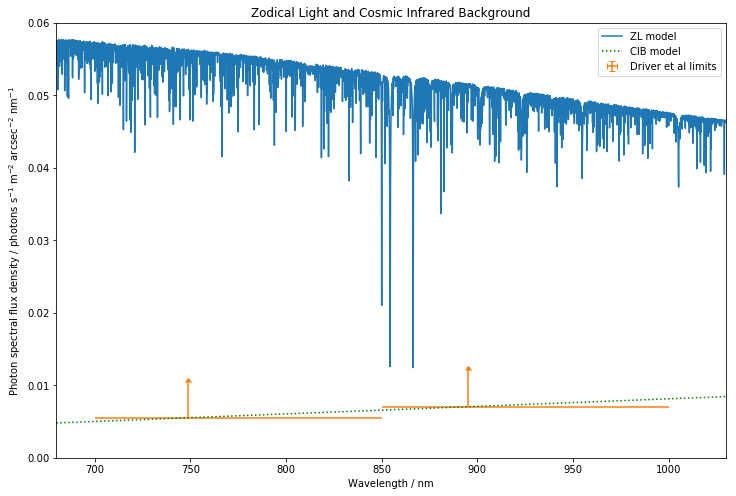

In [34]:
plt.plot(ase_2017.sky.waves.to(u.nm), 
         ase_2017.sky.photon_sfd.to(u.photon * u.s**-1 * u.m**-2 * u.arcsecond**-2 * u.nm**-1), label='ZL model')
plt.errorbar(cib_waves.to(u.nm).value, cib_limit_photon.value, xerr=((49,45), (101, 105)), 
             yerr=0.005, lolims=True, linestyle='none', label='Driver et al limits')
plt.plot(ase_2017.wavelengths, cib_model(ase_2017.wavelengths), 'g:', label='CIB model')
plt.legend()
plt.xlim(680, 1030)
plt.ylim(0,0.06)
plt.title('Zodical Light and Cosmic Infrared Background')
plt.xlabel('Wavelength / nm')
plt.ylabel('Photon spectral flux density / photons s$^{-1}$ m$^{-2}$ arcsec$^{-2}$ nm$^{-1}$')
plt.gcf().set_size_inches(12,8)

Now calculate expect signal and noise for ZL and CIB

In [35]:
t_exp = 1 * 30 * u.day * duty_cycle * filter_fraction
t_sub = 40 * u.minute

virtual_nb_data = {}
filter_fraction = 1 / 6

for filter_name in ase_2016.filter_names:
    cib_signal, noise = ase_2016.extended_source_signal_noise(surface_brightness=cib_model,
                                                              filter_name=filter_name,
                                                              total_exp_time=t_exp,
                                                              sub_exp_time=t_sub,
                                                              calc_type='per arcsecond squared')
    zl_signal, noise_again = ase_2016.extended_source_signal_noise(surface_brightness=None,
                                                                   filter_name=filter_name,
                                                                   total_exp_time=t_exp,
                                                                   sub_exp_time=t_sub,
                                                                   calc_type='per arcsecond squared')
    virtual_nb_data[filter_name] = (cib_signal, zl_signal, noise)
    
standard_data = {}
filter_fraction = 1 / 4

for filter_name in ase_2017.filter_names:
    cib_signal, noise = ase_2017.extended_source_signal_noise(surface_brightness=cib_model,
                                                              filter_name=filter_name,
                                                              total_exp_time=t_exp,
                                                              sub_exp_time=t_sub,
                                                              calc_type='per arcsecond squared')
    zl_signal, noise_again = ase_2017.extended_source_signal_noise(surface_brightness=None,
                                                                   filter_name=filter_name,
                                                                   total_exp_time=t_exp,
                                                                   sub_exp_time=t_sub,
                                                                   calc_type='per arcsecond squared')
    standard_data[filter_name] = (cib_signal, zl_signal, noise)

In [36]:
virtual_nb_data

{'ase_i1': (<Quantity 829.3518884002762 electron / arcsec2>,
  <Quantity 7877.450951163285 electron / arcsec2>,
  <Quantity 100.24576845945118 electron / arcsec2>),
 'ase_i2': (<Quantity 844.6576008227175 electron / arcsec2>,
  <Quantity 7985.606660959049 electron / arcsec2>,
  <Quantity 100.85968231282558 electron / arcsec2>),
 'ase_i3': (<Quantity 861.5145969805633 electron / arcsec2>,
  <Quantity 8118.613836604536 electron / arcsec2>,
  <Quantity 101.59990003955436 electron / arcsec2>),
 'ase_z1': (<Quantity 323.8590764587197 electron / arcsec2>,
  <Quantity 2238.5744493935917 electron / arcsec2>,
  <Quantity 62.4887572313184 electron / arcsec2>),
 'ase_z2': (<Quantity 308.0338567758774 electron / arcsec2>,
  <Quantity 2125.651772717327 electron / arcsec2>,
  <Quantity 61.4499543039337 electron / arcsec2>),
 'ase_z3': (<Quantity 293.00434855366456 electron / arcsec2>,
  <Quantity 2009.2313242809664 electron / arcsec2>,
  <Quantity 60.37091126773694 electron / arcsec2>)}

In [37]:
standard_data

{'ase_i1': (<Quantity 829.3518884002762 electron / arcsec2>,
  <Quantity 7877.450951163285 electron / arcsec2>,
  <Quantity 100.24576845945118 electron / arcsec2>),
 'ase_nb855': (<Quantity 11.008567155069677 electron / arcsec2>,
  <Quantity 75.661457482193 electron / arcsec2>,
  <Quantity 37.80319138775983 electron / arcsec2>),
 'ase_nb858': (<Quantity 10.686865271476671 electron / arcsec2>,
  <Quantity 82.5047667997096 electron / arcsec2>,
  <Quantity 37.88935056890686 electron / arcsec2>),
 'ase_z3': (<Quantity 293.00434855366456 electron / arcsec2>,
  <Quantity 2009.2313242809664 electron / arcsec2>,
  <Quantity 60.37091126773694 electron / arcsec2>)}

In reality we'll do something far more sophisticated (and correct) but for a rough estimate of signal to noise in the derived ZL and CIB photometry use a very simple model with least squares fitting.